## RNN - Character Level Model for name generation.
Based on Coursera Course on Sequence Models.
- Using Recurrent Neural Networks it generates random names.
- Network is trained on Baby names.
Different names of babies born in the year 2017.
- Training done on Google's Colab.


In [3]:
!ls


drive  sample_data


In [0]:
import numpy as np
#from utils import *
import random
import pandas as pd
import pickle

### Important Functions

In [0]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')

def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t

def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    ### START CODE HERE ###
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    ### END CODE HERE ###
    
    return gradients, a


### Dataset

In [0]:
names_list = pd.read_csv('drive/My Drive/Colab Notebooks/character level model/yob2017.txt',header=None)
boy_names = names_list[names_list[1]=='M'][0].apply(str.lower)
girl_names = names_list[names_list[1] == 'F'][0].apply(str.lower)
combined = names_list[0]

In [0]:
def get_names_string(names_list):
    '''
    takes list like object and returns elements concatinated in string form.
    '''
    str_names = ''
    for name in names_list:
        str_names += name + '\n'
    return(str_names.lower())
def get_chars_data_size_vocab_size(data):
    '''
    Takes a list like data and return 
    i.characters in it.
    ii. string representation.
    iii. data size
    iv. vocab size
    return (chars,names,data_size, vocab_size)
    '''
    names = get_names_string(data)
    chars = list(set(names))
    data_size, vocab_size = len(names), len(chars)
    print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
    return (chars,names,data_size, vocab_size)


def get_dicss(characters):
    '''
    Return dictionaries
    Characters -> to Index
    Index -> to Characters
    return (ix_to_char,char_to_ix)
    '''
    char_to_ix = { ch:i for i,ch in enumerate(sorted(characters)) }
    ix_to_char = { i:ch for i,ch in enumerate(sorted(characters)) }
    print('Printing Index to Characters\n',ix_to_char)
    return (ix_to_char,char_to_ix)

### Clipping gradients 

In [0]:
def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWax, dWaa, dWya, db, dby]:
        
        np.clip(gradient, -maxValue, maxValue, gradient)

    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [0]:
def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    ### START CODE HERE ###
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a,1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax,x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya,a) + by
        y = softmax(z)
        
        # for grading purposes
        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
    
        # for grading purposes
        seed += 1
        counter +=1
        
    ### END CODE HERE ###

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [0]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [0]:

def model(data, ix_to_char, char_to_ix, num_iterations = 10000, n_a = 500, sample_no = 10, vocab_size = 27):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    sample_no -- number of names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """

    # Retrieve n_x and n_y from vocab_size
    iter_loss = []
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, sample_no)
    
    # Build list of all dinosaur names (training examples).

    examples = data.split('\n')
    
    # Shuffle list of all  names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    for j in range(num_iterations):     
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j% 100 == 0:
          iter_loss.append(loss)
        if j % 2000 == 0:
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of names to print
            seed = 0
            for name in range(sample_no):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
        
    return (parameters,iter_loss)

In [31]:
# Boys_names
chars, boy_strings,data_size,vocab_size= get_chars_data_size_vocab_size(boy_names)
ix_to_char,char_to_ix = get_dicss(chars)
# Girls_names
chars, girl_strings,data_size,vocab_size= get_chars_data_size_vocab_size(girl_names)
ix_to_char,char_to_ix = get_dicss(chars)
# Combined
chars, combined_strings,data_size,vocab_size= get_chars_data_size_vocab_size(combined)
ix_to_char,char_to_ix = get_dicss(chars)

There are 98348 total characters and 27 unique characters in your data.
Printing Index to Characters
 {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
There are 133370 total characters and 27 unique characters in your data.
Printing Index to Characters
 {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
There are 231718 total characters and 27 unique characters in your data.
Printing Index to Characters
 {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: '

## Trainig of different models

### Boys

In [71]:

parameters_b, iter_loss_b = model(boy_strings, ix_to_char, char_to_ix, num_iterations=50000)
with open('drive/My Drive/Colab Notebooks/character level model/boy_params.txt', 'wb') as file:
  pickle.dump(parameters_b, file)
with open('drive/My Drive/Colab Notebooks/character level model/boy_iter_loss_b.txt', 'wb') as file:
  pickle.dump(iter_loss_b, file)

Iteration: 0, Loss: 32.951764

Nkzxwtdmfqoeyhsqwasjjjvu
Kneb
Kzxwtdmfqoeyhsqwasjjjvu
Neb
Zxwtdmfqoeyhsqwasjjjvu
Eb
Xwtdmfqoeyhsqwasjjjvu
B
Wtdmfqoeyhsqwasjjjvu



Iteration: 2000, Loss: 21.260548

Ikytsodharidweonm
En
Eytrodharidweonm
Idaaeor
Yuuran
Ab
Tsodidkievdllr
Aaepsac
Todidkievdllr



Iteration: 4000, Loss: 18.452282

Jaytri
Heh
Hyvrn
Jac
Yuur
Ab
Uus
A
Tohfanbcxerir



Iteration: 6000, Loss: 17.727077

Kayson
Haia
Huvon
Kac
Ytrlan
Caagon
Utoi
Aagoo
Togibkfayer
Aespe


Iteration: 8000, Loss: 17.362597

Keyvor
Haic
Hyvro
Kacahisabarrevailumadyakir
Yuvian
Baafroi
Uusan
Aafroi
Tpardin
Ahote


Iteration: 10000, Loss: 17.050682

Keytrial
Ilea
Iytsn
Kad
Zstpbien
Caahis
Uusamaribujlis
Aagro
Tojeen
Ahnse


Iteration: 12000, Loss: 16.687856

Kayton
Geed
Huuto
Kacaeqsad
Yuto
Caagon
Utohah
Aaerol
Toen
Ador


Iteration: 14000, Loss: 16.618971

Keytri
Imad
Juvon
Kad
Yutr
Baahio
Uusan
Aagon
Tran
Ahrom


Iteration: 16000, Loss: 16.730751

Leyson
Jehaajio
Kytsol
Lacaen
Zrysen
Daafor
Voran
Aador


### GIrls

In [74]:
% timeit
parameters_g,iter_loss_g = model(girl_strings, ix_to_char, char_to_ix,num_iterations = 50000)

with open('drive/My Drive/Colab Notebooks/character level model/girl_params.txt', 'wb') as file:
  pickle.dump(parameters_g, file)
with open('drive/My Drive/Colab Notebooks/character level model/girl_iter_loss_b.txt', 'wb') as file:
  pickle.dump(iter_loss_g, file)

Iteration: 0, Loss: 32.945184

Nkzxwtdmfqoeyhsqwasjjjvu
Kneb
Kzxwtdmfqoeyhsqwasjjjvu
Neb
Zxwtdmfqoeyhsqwasjjjvu
Eb
Xwtdmfqoeyhsqwasjjjvu
B
Wtdmfqoeyhsqwasjjjvu



Iteration: 2000, Loss: 21.010473

Kgyytramdinayanjsariiini
Hie
Iyturancmieyanitariiirn
Kacahrse
Yturancni
Ba
Uuranengayerjsariienm
A
Traneni



Iteration: 4000, Loss: 18.334722

Leyrnn
Haia
Hyssnah
Laa
Yrrjanaliavarisanagesramleya
Aa
Tsranamdaycketanahasoaltayeh
A
Sranamdaycketanahasoaltayeh



Iteration: 6000, Loss: 17.455795

Liynna
Jka
Kystoaaamgcycnly
Lba
Ystra
Da
Ttradaelay
A
Srala
Aerra


Iteration: 8000, Loss: 17.229444

Leysni
Kieb
Kysslanameeyales
Lecaenna
Yrorah
Daainn
Sspbleni
A
Sranaleavarisanaharkannaya
Airmaa


Iteration: 10000, Loss: 16.856747

Liyori
Jela
Jwusra
Laca
Ystlah
Ca
Turai
A
Srana
Aenn


Iteration: 12000, Loss: 16.926707

Liyosi
Jie
Kystjah
Lee
Yttlen
Da
Usraiahaevdiloa
A
Soelana
Ahnna


Iteration: 14000, Loss: 16.517499

Mayssode
Jeibaanna
Kyusrah
Madaeroe
Zsuralandatalin
Caahnna
Ttoheene
A
Sramani


### Combined

In [75]:
parameters_c, iter_loss_c = model(combined_strings, ix_to_char, char_to_ix,num_iterations = 50000)
with open('drive/My Drive/Colab Notebooks/character level model/c_params.txt', 'wb') as file:
  pickle.dump(parameters_c, file)
with open('drive/My Drive/Colab Notebooks/character level model/boy_iter_loss_c.txt', 'wb') as file:
  pickle.dump(iter_loss_c, file)

Iteration: 0, Loss: 32.951783

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu
B
Wtdmfqoeyhsqwasjkjvu



Iteration: 2000, Loss: 21.279099

Iiyssnalaneawaonn
Gica
Hytrialaneawaonn
Ida
Ytsnalaneawaonn
A
Utnalaneawaonn
A
Tochaneawaonn



Iteration: 4000, Loss: 18.630176

Kaysria
Haja
Hysriaa
Kaa
Yrriaa
Aa
Tsoelana
A
Spamane



Iteration: 6000, Loss: 17.883091

Leyssodeenmaykmes
Jeibaeroka
Juusokeenmaykmes
Laa
Yssoimanlayjnis
Da
Troflanlayiner
A
Soimanlayiner
Ahora


Iteration: 8000, Loss: 17.581611

Lfyssi
Jei
Kytti
Led
Yttn
Da
Ttrah
A
Soje
Ahor


Iteration: 10000, Loss: 17.382188

Khyssa
Jie
Jxysr
Kad
Zuvlak
Caahin
Tusan
Aahlr
Soki
Ahqse


Iteration: 12000, Loss: 17.352950

Keysih
Jaia
Juush
Kad
Yuto
Caahen
Ttra
Aaion
Sole
Aisol


Iteration: 14000, Loss: 17.148203

Leystn
Jiee
Kysto
Lee
Zutra
Daaisr
Uurch
Aaiss
Tolibma
Ahrre


Iteration: 16000, Loss: 16.920076

Keystobedin
Jeic
Jutrlak
Kacaenn
Ztrmah
Daahlna
Trlcieleatbris
Aahora


In [0]:
import seaborn as sns
sns.set(style="darkgrid")

In [0]:
x = pd.DataFrame(iter_loss_b, index = range(len(iter_loss_b)))

### Loss Curve

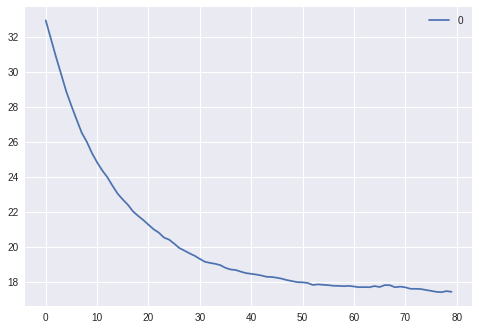

In [58]:
x.plot()

### Using the saved weights

In [0]:
with open('drive/My Drive/Colab Notebooks/character level model/boy_params.txt', 'wb') as file:
  pickle.dump(parameters, file)


In [0]:
# reading Pickle file
def read_pickle(path):
  objects = []
  with (open(path, "rb")) as openfile:
      while True:
          try:
              objects.append(pickle.load(openfile))
          except EOFError:
              break
  return objects

In [0]:
boy_iter = read_pickle('drive/My Drive/Colab Notebooks/character level model/boy_iter_loss_b.txt')
boy_params = read_pickle('drive/My Drive/Colab Notebooks/character level model/boy_params.txt')

In [28]:
boy_params[0]

{'Waa': array([[-0.00500982,  0.01631995, -0.00216826, ...,  0.00880142,
         -0.00337585,  0.00439502],
        [ 0.00789849, -0.00437543,  0.01317384, ..., -0.00150877,
         -0.00148728,  0.01021571],
        [-0.01154183, -0.00571715, -0.00036941, ...,  0.00178756,
          0.00616333, -0.00020538],
        ...,
        [ 0.00308257,  0.00690143,  0.01186455, ...,  0.00342417,
          0.00358696, -0.013164  ],
        [ 0.00955497, -0.00586507, -0.00239647, ..., -0.00640822,
          0.01114331, -0.00129419],
        [ 0.01271503, -0.02140724,  0.00037829, ...,  0.02295093,
         -0.01721804,  0.00894287]]),
 'Wax': array([[ 0.01624345, -0.06383082, -0.18113521, ...,  0.13468916,
          0.05862426,  0.0503086 ],
        [-0.00935769, -0.21490386,  0.08396738, ...,  0.06514132,
         -0.05091902, -0.02617031],
        [-0.00208894,  0.14592238,  0.25981087, ...,  0.19239539,
          0.12667525,  0.38643273],
        ...,
        [ 0.0035927 ,  0.07124523, -0.12

In [0]:
boy_iter  = pd.DataFrame(data = boy_iter[0],columns = ['loss_b'],index = range(len(boy_iter[0])))

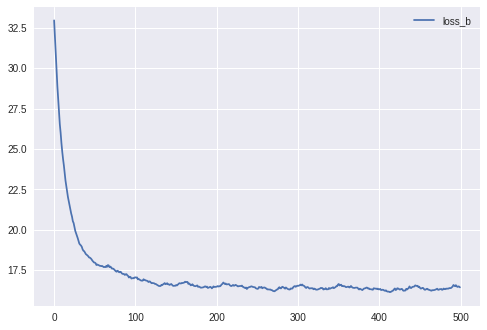

In [24]:
boy_iter.plot()

## Prediction using the saved weights/learned weights.

In [36]:
# for Prediction
seed = 4
for name in range(10):
  # Sample indices and print them
  sampled_indices = sample(boy_params[0], char_to_ix, seed)
  print_sample(sampled_indices, ix_to_char)
  seed += 1  # To get the same result for grading purposed, increment the seed by one. 
  print('\n')

Zrtol


Caadkom


Ttren


Aadon


Tohein


Aerqi


Randin


Brreb


Bickieuleme


Rred


